In [1]:
import numpy as np
import time
import sys

import random
import csv
import math
import matplotlib.pyplot as plt

In [37]:
def heuristique_simple(jobs):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    
    jobs_done = []
    solution = []
    tps_exec = []
    for m in range(M):
        solution.append([])
        tps_exec.append(0)
        
    for j in range(J):
        
        min_machine = tps_exec.index(min(tps_exec))
        min_tps_exec =  tps_exec[min_machine]

        min_job = 0
        min_job_time = 100000
        for i in range(J):
            if jobs[min_machine][i] < min_job_time and not i in jobs_done:
                min_job_time = jobs[min_machine][i]
                min_job = i
                
        solution[min_machine].append(min_job)
        jobs_done.append(min_job)
        tps_exec[min_machine] += min_job_time

    program_time = time.perf_counter() - t
    
    return solution, max(tps_exec), program_time

def heuristique_stupide_v2(jobs):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    
    jobs_done = []
    solution = []
    tps_exec = []
    for m in range(M):
        solution.append([])
        tps_exec.append(0)
        
    for i in range(J):
        min_job = -1
        min_machine = -1
        min_time = 100000
        for j in range(J):
            future_exec_time = np.asarray(tps_exec) + np.asarray(jobs)[:,j]
            for m in range(M):
                if future_exec_time[m] < min_time and not j in jobs_done:
                    min_job = j
                    min_machine = m
                    min_time = future_exec_time[m]
                
        solution[min_machine].append(min_job)
        jobs_done.append(min_job)
        tps_exec[min_machine] = min_time

    program_time = time.perf_counter() - t
    
    print(solution)
    print(tps_exec)
    return solution, max(tps_exec), program_time

In [3]:
def format_solution(num, jobs, sol, objective, time): 
    M = len(jobs)
    J = len(jobs[0])
    
    file = open("output.txt", "w")
    print("%d,%d,%d" % (num, M, J), file=file)
    print("---", file=file)
    for m in range(M):
        start_time = 0
        for j in sol[m]:
            print("%d,%d,%d,%d" % (m, j, start_time, start_time + jobs[m][j]), file=file)
            start_time += jobs[m][j]
                
    print("---", file=file)
    print("%.15f,%d\n" % (time, objective), file=file)

In [44]:
class ReadingError(Exception):
    pass

def build_summaries(csvfile):
    output = []
    summary = {}
    with open(csvfile, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='', quoting=csv.QUOTE_NONE)
            matrix = []
            debut = False
            fin = False
            res = None
            i=0
            for row in reader:
                i=i+1
                if len(row) == 0 : 
                    summary['matrix'] = matrix
                    output.append(summary)
                    summary = {}
                    matrix = []
                    res = None 
                    debut = False
                    fin = False 
                elif not debut and not fin and len(row) == 3 and row[0] != "---" :
                    summary['num_matrix'] = int(row[0])
                    summary['nb_task'] = int(row[2])
                    summary['nb_machine'] = int(row[1])
                elif not debut and not fin and len(row) == 1 and row[0] == "---": 
                    debut = True
                elif debut:
                    if row[0] == "---":
                        fin = True
                    elif len(row) == 4:
                        matrix.append(row)
                    elif fin:
                        if len(row) == 2:
                            summary['execution_time'] = row[0]
                            summary['score'] = row[1]
                        else :
                            raise ReadingError("Erreur à la lecture du temps d'exécution et du résultat du solveur, ligne : ", row)
                    else:
                        raise ReadingError("Le fichier est mal formé, ligne : ", row)
                else : 
                    raise ReadingError("Le fichier est très mal formé, ligne : ", row, i)
    return output

def plot_resultat(): 
    out = build_summaries("output.txt")
    for s in out:
        M = s['nb_machine']
        J = s['nb_task']

        # Plot the jobs
        for r in s['matrix']:     
            m = int(r[0])
            j = int(r[1])
            start = int(r[2])
            finish = int(r[3])
            x = [start, finish]
            y = [m+1, m+1]
            plt.plot(x, y, linewidth=4.0, marker='o')
            plt.text(np.mean(x), m+1+0.2, "%d" % j)

        plt.xlabel('Time')
        plt.ylabel('Machine')
        plt.ylim([0,M+1])
        plt.yticks(np.arange(0, M+1, 1.0))
        plt.grid(linestyle=':')
        plt.title("Objectif: %d   Temps d'exécution: %f s" % (int(s['score']), float(s['execution_time'])))
        plt.show()

[[7, 1], [5, 4], [0, 8, 2], [6, 3]]
[10, 10, 11, 10]


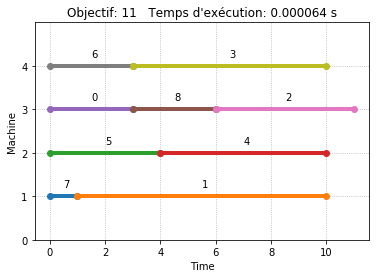

[[7, 4], [8], [0, 2], [5, 6, 1, 3]]
[10, 5, 8, 16]


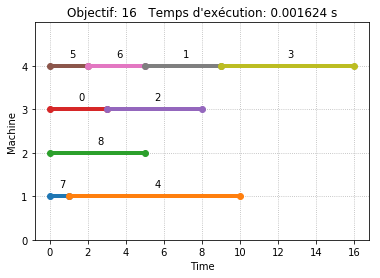

In [5]:
jobs = [[13,9,11,14,9,2,7,1,14],
[14,6,12,13,6,4,12,3,5],
[3,9,5,12,14,5,8,13,3],
[10,4,8,7,9,2,3,10,4]]

sol, objective, time_exec = heuristique_simple(jobs)
format_solution(0, jobs, sol, objective, time_exec)
plot_resultat()

sol, objective, time_exec = heuristique_stupide_v2(jobs)
format_solution(0, jobs, sol, objective, time_exec)
plot_resultat()

In [6]:
def glouton_precedence(jobs, prec):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    
    end_time = [10000000] * J
    jobs_set = []
    
    solution = []
    tps_exec = []
    for m in range(M):
        solution.append([])
        tps_exec.append(0)
        
    for j in range(J):
        
        # Look for the first machine to be ready
        min_machine = tps_exec.index(min(tps_exec))
        min_tps_exec =  tps_exec[min_machine]

        # Find the fastest job on this machine
        min_job = 0
        min_job_time = 100000
        for i in range(J):
            # Check that the job can has not already been executed and that it can be executed now
            if jobs[min_machine][i] < min_job_time and not i in jobs_set and isReadyToRun(i, tps_exec[m], end_time, prec):
                min_job_time = jobs[min_machine][i]
                min_job = i

        solution[min_machine].append(min_job)
        jobs_set.append(min_job)
        tps_exec[min_machine] += min_job_time
        end_time[min_job] = tps_exec[min_machine]
        
    program_time = time.perf_counter() - t
    print(solution)
    print(tps_exec)
    return solution, max(tps_exec), program_time

In [7]:
def isReadyToRun(job, current_time, end_times, prec):
    for (i,j) in prec:
        if j==job:
            if current_time < end_times[i]:
                return False
    return True

def getJobReady(jobs, current_time, end_times, prec):
    for j in jobs:
        if isReadyToRun(j, current_time, end_times, prec):
            return True
    return False

def getConstraintJob(prec, J):
    constraint_value = [0] * J
    for (i,j) in prec:
        constraint_value[i] += 1
        
    constraint_job = []
    max_value = np.max(constraint_value)
    while max_value != 0 and len(constraint_value) > 0:
        max_index = constraint_value.index(max_value)
        constraint_value[max_index] = 0
        constraint_job.append(max_index)
        max_value = np.max(constraint_value)
        
    return constraint_job

def getReadyTime(job, prec, end_time):
    ready_time = -1
    for (i,j) in prec:
        if j==job and end_time[i] > ready_time:
            ready_time = end_time[i]
    return ready_time

In [23]:
def glouton_precedence_v2(jobs, prec):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    end_time = [10000000] * J
    exec_time = [0] * M
    jobs_set = []
    
    solution = []
    for m in range(M):
        solution.append([])
             
    # First, try to run the jobs that constraint the others, if possible
    constraint_job = getConstraintJob(prec, J)
    for j in constraint_job:
        # Find the machine that can run the job the fastest
        future_exec_time = np.asarray(exec_time) + np.asarray(jobs)[:,j]
        min_machine = -1
        min_machine_time = 1000000
        for m in range(M):
            if future_exec_time[m] < min_machine_time and getReadyTime(j, prec, end_time) <= exec_time[m]:
                min_machine_time = future_exec_time[m]
                min_machine = m
                
        # If a machine was found, run the job on this machine
        # A machine may not be found because the job needs other job(s) to finish first
        if min_machine != -1:
            jobs_set.append(j)
            start_time = exec_time[min_machine]
            exec_time[min_machine] += jobs[min_machine][j]
            end_time[j] = exec_time[min_machine]
            solution[min_machine].append((j, start_time, end_time[j]))
        
    # Set the remaining jobs on the machines
    remaining_jobs = J - len(jobs_set)
    while len(jobs_set) < J:
        k = 0
        job_found = False
        while not job_found:
            # Look for the first machine to be ready
            min_machine = exec_time.index(min(exec_time))
            min_tps_exec =  exec_time[min_machine]

            # Find the fastest job on this machine
            min_job = -1
            min_job_time = 100000
            for i in range(J):
                # Check that the job can has not already been executed and that it can be executed now
                if jobs[min_machine][i] < min_job_time and not i in jobs_set and getReadyTime(i, prec, end_time) <= exec_time[m] + k:
                    min_job_time = jobs[min_machine][i]
                    min_job = i
                    
            if min_job != -1:
                jobs_set.append(min_job)
                start_time = exec_time[min_machine] + k
                exec_time[min_machine] += k + min_job_time
                end_time[min_job] = exec_time[min_machine]
                solution[min_machine].append((min_job, start_time, end_time[min_job]))
                job_found = True
            else:
                k += 1
        
    program_time = time.perf_counter() - t
    return solution, max(exec_time), program_time

def glouton_precedence_v2_1(jobs, prec):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    end_time = [10000000] * J
    exec_time = [0] * M
    jobs_set = []
    
    solution = []
    for m in range(M):
        solution.append([])
             
    # First, try to run the jobs that constraint the others, if possible
    constraint_job = getConstraintJob(prec, J)
    for j in constraint_job:
        # Find the machine that can run the job the fastest
        future_exec_time = np.asarray(exec_time) + np.asarray(jobs)[:,j]
        min_machine = -1
        min_machine_time = 1000000
        for m in range(M):
            if future_exec_time[m] < min_machine_time and getReadyTime(j, prec, end_time) <= exec_time[m]:
                min_machine_time = future_exec_time[m]
                min_machine = m
                
        # If a machine was found, run the job on this machine
        # A machine may not be found because the job needs other job(s) to finish first
        if min_machine != -1:
            jobs_set.append(j)
            start_time = exec_time[min_machine]
            exec_time[min_machine] += jobs[min_machine][j]
            end_time[j] = exec_time[min_machine]
            solution[min_machine].append((j, start_time, end_time[j]))
        
    # Set the remaining jobs on the machines
    remaining_jobs = J - len(jobs_set)
    while len(jobs_set) < J:
        # Look for the first machine ready
        min_machine = exec_time.index(min(exec_time))
        min_tps_exec =  exec_time[min_machine]

        # Find the fastest job on this machine
        min_job = -1
        min_job_time = 100000
        ready_time = 0
        for i in range(J):
            if not i in jobs_set:
                ready_time = getReadyTime(i, prec, end_time) 
                if ready_time < exec_time[min_machine]:
                    ready_time = exec_time[min_machine]

                if ready_time + jobs[min_machine][i] < min_job_time:
                    min_job_time = ready_time + jobs[min_machine][i]
                    min_job = i

        jobs_set.append(min_job)
        exec_time[min_machine] = min_job_time
        end_time[min_job] = exec_time[min_machine]
        solution[min_machine].append((min_job, min_job_time - jobs[min_machine][min_job], end_time[min_job]))
        
    program_time = time.perf_counter() - t
    return solution, max(exec_time), program_time

def glouton_precedence_v3(jobs, prec):
    t = time.perf_counter()
    
    M = len(jobs)
    J = len(jobs[0])
    end_time = [10000000] * J
    exec_time = [0] * M
    jobs_set = []
    
    solution = []
    for m in range(M):
        solution.append([])
        
    # First, try to run the jobs that constraint the others, if possible
    constraint_job = getConstraintJob(prec, J)
    for j in constraint_job:
        # Find the machine that can run the job the fastest
        future_exec_time = np.asarray(exec_time) + np.asarray(jobs)[:,j]
        min_machine = -1
        min_machine_time = 1000000
        for m in range(M):
            if future_exec_time[m] < min_machine_time and isReadyToRun(j, exec_time[m], end_time, prec):
                min_machine_time = future_exec_time[m]
                min_machine = m
                
        # If a machine was found, run the job on this machine
        # A machine may not be found because the job needs other job(s) to finish first
        if min_machine != -1:
            jobs_set.append(j)
            start_time = exec_time[min_machine]
            exec_time[min_machine] += jobs[min_machine][j]
            end_time[j] = exec_time[min_machine]
            solution[min_machine].append((j, start_time, end_time[j]))
        
    # Set the remaining jobs on the machines
    remaining_jobs = J - len(jobs_set)
    while len(jobs_set) < J:
        k = 0
        job_found = False
        while not job_found:
            min_job = -1
            min_machine = -1
            min_time = 100000
            for j in range(J):
                future_exec_time = np.asarray(exec_time) + np.asarray(jobs)[:,j] + k
                for m in range(M):
                    if future_exec_time[m] < min_time and not j in jobs_set and isReadyToRun(j, exec_time[m] + k, end_time, prec):
                        min_job = j
                        min_machine = m
                        min_time = future_exec_time[m]
                        
            if min_job != -1 and min_machine != -1:
                jobs_set.append(min_job)
                start_time = exec_time[min_machine] + k
                exec_time[min_machine] = min_time
                end_time[min_job] = exec_time[min_machine]
                solution[min_machine].append((min_job, start_time, end_time[min_job]))
                job_found = True
            else:
                k += 1
        
    program_time = time.perf_counter() - t
    return solution, max(exec_time), program_time

def glouton_precedence_v4(jobs, prec):
    t = time.perf_counter()
    
    # Nombre de machines et de jobs
    M = len(jobs)
    J = len(jobs[0])
    
    # Date de fin de chaque job
    end_time = [10000000] * J
    
    # Temps de travail de chaque machine
    exec_time = [0] * M
    
    # Liste des jobs placés
    jobs_set = []
    
    # Liste de tuples (num_job, date_début, date_fin) pour chaque machine
    solution = []
    for m in range(M):
        solution.append([])
        
    # Au début, essayer de placer les jobs qui précèdent d'autres jobs
    # Ces jobs doivent se finir le plus tôt possible pour se libérer de leurs contraintes
    constraint_job = getConstraintJob(prec, J)
    for j in constraint_job:
        # Trouver la machine qui finira d'exécuter le job avant les autres
        future_exec_time = np.asarray(exec_time) + np.asarray(jobs)[:,j]
        min_machine = -1
        min_machine_time = 1000000
        for m in range(M):
            if future_exec_time[m] < min_machine_time and getReadyTime(j, prec, end_time) <= exec_time[m]:
                min_machine_time = future_exec_time[m]
                min_machine = m
                
        # Si une machine a été trouvé, alors exécuter le job dessus
        # Il est possible qu'on ne trouve pas de machine si le job nécessite la fin d'un autre pour s'exécuter
        if min_machine != -1:
            jobs_set.append(j)
            start_time = exec_time[min_machine]
            exec_time[min_machine] += jobs[min_machine][j]
            end_time[j] = exec_time[min_machine]
            solution[min_machine].append((j, start_time, end_time[j]))
        
    # Placer les jobs restants sur les machines
    remaining_jobs = J - len(jobs_set)
    while len(jobs_set) < J:
        
        # Trouver le couple job-machine qui minimise la fin d'exécution
        min_job = -1
        min_machine = -1
        min_time = 100000
        for j in range(J):
            for m in range(M):
                # Si le job n'a pas encore été placé
                if not j in jobs_set:
                    # Si le job ne peut pas encore être exécuté, calculer le temps d'attente nécessaire pour être prêt
                    #time_before_ready = 0
                    #gap = 0
                    
                    ready_time = getReadyTime(j, prec, end_time) 
                    if ready_time < exec_time[m]:
                        ready_time = exec_time[m]
                    
                    #if not isReadyToRun(j, exec_time[m], end_time, prec):
                    #    ready_time = getReadyTime(j, prec, end_time)
                    #    if ready_time > exec_time[m]:
                    #        time_before_ready = ready_time - exec_time[m]
                    #        gap = 1

                    # Est ce que la date de fin d'exécution est plus intéressante ? Si oui, garder le couple job-machine
                    future_exec_time = ready_time + jobs[m][j]
                    if future_exec_time < min_time:
                        min_job = j
                        min_machine = m
                        min_time = future_exec_time

        # Placer le job sur la machine, mise à jour des dates de fin de chaque machine et job
        jobs_set.append(min_job)
        start_time = min_time - jobs[min_machine][min_job]
        exec_time[min_machine] = min_time
        end_time[min_job] = exec_time[min_machine]
        solution[min_machine].append((min_job, start_time, end_time[min_job]))
            
        
    program_time = time.perf_counter() - t
    return solution, max(exec_time), program_time

In [24]:
def format_solution_prec(num, jobs, sol, objective, time): 
    M = len(jobs)
    J = len(jobs[0])
    
    file = open("output.txt", "w")
    print("%d,%d,%d" % (num, M, J), file=file)
    print("---", file=file)
    for m in range(M):
        start_time = 0
        for j in sol[m]:
            print("%d,%d,%d,%d" % (m, j[0], j[1], j[2]), file=file)
            start_time += jobs[m][j[0]]
                
    print("---", file=file)
    print("%.15f,%d\n" % (time, objective), file=file)

Heuristique précédence v2


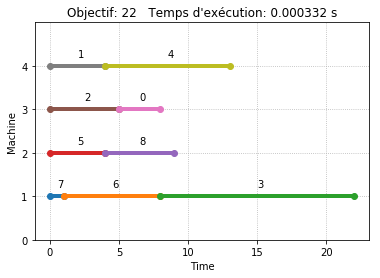

Heuristique précédence v2.1


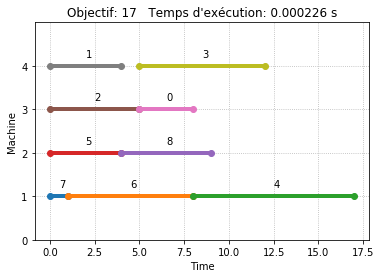

Heuristique précédence v4


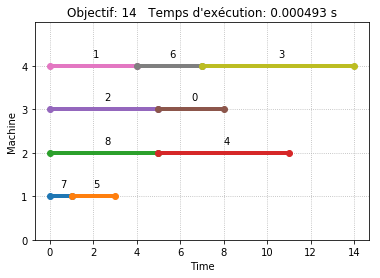

In [26]:
jobs = [[13, 9, 11, 14, 9,  2, 7,   1, 14],
        [14, 6, 12, 13, 6,  4, 12,  3, 5],
        [3,  9, 5,  12, 14, 5, 8,  13, 3],
        [10, 4, 8,  7,  9,  2, 3,  10, 4]]

prec = [[2, 3],
        [1, 4]]
#prec = [[2, 3],[3, 4]]

# AVEC PRECEDENCE
print("Heuristique précédence v2")
sol, objective, time_exec = glouton_precedence_v2(jobs, prec)
format_solution_prec(0, jobs, sol, objective, time_exec)
plot_resultat()

print("Heuristique précédence v2.1")
sol, objective, time_exec = glouton_precedence_v2_1(jobs, prec)
format_solution_prec(0, jobs, sol, objective, time_exec)
plot_resultat()

#print("Heuristique précédence v3")
#sol, objective, time_exec = glouton_precedence_v3(jobs, prec)
#format_solution_prec(0, jobs, sol, objective, time_exec)
#plot_resultat()

print("Heuristique précédence v4")
sol, objective, time_exec = glouton_precedence_v4(jobs, prec)
format_solution_prec(0, jobs, sol, objective, time_exec)
plot_resultat()

# v2.1 et v4 ont l'air équivalents, à tester

[[7, 1], [5, 4], [0, 8, 2], [6, 3]]
[10, 10, 11, 10]


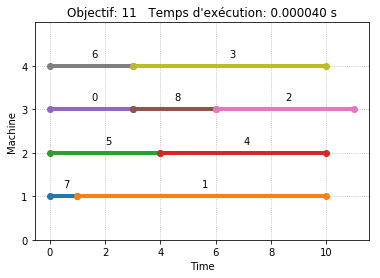

[[7, 4], [8], [0, 2], [5, 6, 1, 3]]
[10, 5, 8, 16]


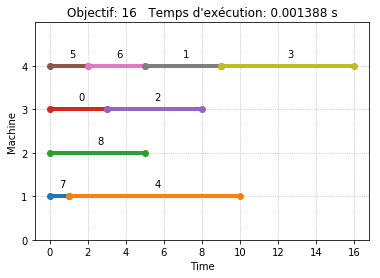

In [12]:
jobs = [[13, 9, 11, 14, 9,  2, 7,   1, 14],
        [14, 6, 12, 13, 6,  4, 12,  3, 5],
        [3,  9, 5,  12, 14, 5, 8,  13, 3],
        [10, 4, 8,  7,  9,  2, 3,  10, 4]]

prec = [[2, 3],
        [1, 4]]
prec = [[2, 3],[3, 4]]

# SANS PRECEDENCE
sol, objective, time_exec = heuristique_stupide(jobs)
format_solution(0, jobs, sol, objective, time_exec)
plot_resultat()

sol, objective, time_exec = heuristique_stupide_v2(jobs)
format_solution(0, jobs, sol, objective, time_exec)
plot_resultat()

In [158]:
prec = [[1, 3],
        [1, 4],
        [2, 4],
        [5, 6],
        [3, 4],
        [3, 5],
        [3, 6]]
getConstraintJob(prec, 7)
solution = [[]] * 5

<h1>TEST BENCHMARK SOMETHING</h1>

In [30]:
def create_test(file, nb_machines, nb_taches, cout_maximal, nb_tests): 
    # Il faut changer la graine pour avoir des nouvelles matrices aléatoires.
    random.seed(40)

    with open(file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='', quoting=csv.QUOTE_NONE)
        for k in range(0,nb_tests): 
            l = [[random.randint(1,cout_maximal) for j in range(nb_taches)] for i in range(nb_machines)]
            writer.writerow([k])
            writer.writerows(l)
            writer.writerow([])         

In [39]:
def check_solution(num_matrix, matrix, score, nb_task):
    #Check if there is an overlaping on the given matrix
    matrix[0][0]
    currMachine = -1
    jobs = []
    currMachine = matrix[0][0]
    admissible = True
    for i in matrix:
        debut = i[2]
        fin = i[3]
        if i[0] == currMachine:
            jobs.append((debut,fin))
        elif i[0] != currMachine:
            admissible = admissible and check_machine(jobs)
            if not admissible:
                print("Overlapping sur matrice ", num_matrix)
            jobs=[(debut,fin)]
            currMachine = i[0]
    #For the last machine
    admissible = admissible and check_machine(jobs)
    if not admissible:
        print("Overlapping sur matrice ", num_matrix)
        return admissible
    
    #Check if all the tasks have been executed exactly once
    by_task = sorted(matrix, key=lambda line: int(line[1]))
    for i,j in zip(by_task, range(nb_task)):
        if int(i[1]) != int(j): 
            print("il manque ",i[1])
            admissible = admissible and False
            
    if not admissible: 
        print("Il manque une tache dans la matrice", num_matrix)
        return admissible
    
    #Check if the optimal result found is the max of the end date.
    last = max([int(i[3]) for i in matrix])
    admissible = admissible and (last == int(score))
    if not admissible: 
        print(last,",",score)
        print("Résultat incorrect dans la matrice", num_matrix)
        return admissible
    
    return admissible

#check if jobs do not overlap on a single machine
def check_machine(jobs): 
    jobs = sorted(jobs, key=lambda job: job[0])
    for i in range(len(jobs)):
        if i != (len(jobs)-1):
            if jobs[i][0] <= jobs[i+1][0] and jobs[i][1] > jobs[i+1][0]:
                return False            
    return True

In [40]:
def create_matrix_list_from_csv(inputfile):
    list_of_matrix=[]
    with open(inputfile, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        matrix = []
        
        for line in spamreader:
            if line==[] or len(line) == 1:
                list_of_matrix.append(matrix)
                matrix=[]
            else:
                row = []
                for cell in line:
                    row.append(int (cell))
                matrix.append(row)  
                
        if (matrix!=[]):
            list_of_matrix.append(matrix)
        return list_of_matrix

In [46]:
class ReadingError(Exception):
    pass

def build_summaries(csvfile):
    output = []
    summary = {}
    with open(csvfile, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='', quoting=csv.QUOTE_NONE)
            matrix = []
            debut = False
            fin = False
            res = None
            i=0
            for row in reader:
                i=i+1
                if len(row) == 0 : 
                    summary['matrix'] = matrix
                    output.append(summary)
                    summary = {}
                    matrix = []
                    res = None 
                    debut = False
                    fin = False 
                elif not debut and not fin and len(row) == 3 and row[0] != "---" :
                    summary['num_matrix'] = int(row[0])
                    summary['nb_task'] = int(row[1])
                    summary['nb_machine'] = int(row[2])
                elif not debut and not fin and len(row) == 1 and row[0] == "---": 
                    debut = True
                elif debut:
                    if row[0] == "---":
                        fin = True
                    elif len(row) == 4:
                        matrix.append(row)
                    elif fin:
                        if len(row) == 2:
                            summary['execution_time'] = row[0]
                            summary['score'] = row[1]
                        else :
                            raise ReadingError("Erreur à la lecture du temps d'exécution et du résultat du solveur, ligne : ", row)
                    else:
                        raise ReadingError("Le fichier est mal formé, ligne : ", row)
                else : 
                    raise ReadingError("Le fichier est très mal formé, ligne : ", row, i)
    return output 

In [56]:
def test_heuristique(inputfile, outputfile):
        
    file = open(outputfile, 'w')

    list_of_matrix = create_matrix_list_from_csv(inputfile)
    id_matrix=0
    for matrix in list_of_matrix:
        if matrix!=[]:
            M = len(matrix)
            J = len(matrix[0])
            sol, objectif, program_time = heuristique_simple(matrix)

            if (sol):   
                print("%d,%d,%d" % (id_matrix, M, J), file=file)
                print("---", file=file)
                for m in range(M):
                    start_time = 0
                    for j in sol[m]:
                        print("%d,%d,%d,%d" % (m, j, start_time, start_time + matrix[m][j]), file=file)
                        start_time += matrix[m][j]

                print("---", file=file)
                print("%.15f,%d\n" % (program_time, objectif), file=file)
            else:
                print("error: No solution found", file=file)

            id_matrix+=1

In [58]:
def benchmark(nb_machines, nb_taches, cout_max, nb_tests):
    
    print("Benchmark de ", nb_tests, " tests pour ", nb_machines, "machines, ", nb_taches, "taches et un cout maximal de ", cout_max)
    
    summary_test = {}
    summary_test['nb_machines'] = nb_machines
    summary_test['nb_taches'] = nb_taches
    summary_test['cout_max'] = cout_max
    summary_test['nb_tests'] = nb_tests
    
    print("    - Creation du fichier de test...")
    testfile = "tests_" + str(nb_machines) + "_" + str(nb_taches) + "_" + str(cout_max) + "_" + str(nb_tests) + ".csv"
    summary_test['testfile'] = testfile
    create_test(testfile, nb_machines=nb_machines, nb_taches=nb_taches, cout_maximal=cout_max, nb_tests=nb_tests)
    print("    - Done.")
    
    print("    - Génération des solutions en Glouton...")
    solution_heuristique = "solutions_" + str(nb_machines) + "_" + str(nb_taches) + "_" + str(cout_max) + "_" + str(nb_tests) + "_Glouton.csv"
    summary_test['solution_Glouton'] = solution_heuristique
    test_heuristique(testfile, solution_heuristique)
    print("    - Done.")
    
    print("    - Génération des solutions en PPC...")
    solution_PPC = "solutions_" + str(nb_machines) + "_" + str(nb_taches) + "_" + str(cout_max) + "_" + str(nb_tests) + "_PPC.csv"
    summary_test['solution_PPC'] = solution_PPC
    test_job_scheduling_PPC(testfile, solution_PPC)
    print("    - Done.")
    
    print("    - Vérification des solution de Glouton...")
    list_summaries_Glouton = build_summaries(solution_heuristique)
    nb_admissible_Glouton = 0
    for summary in list_summaries_Glouton:
        admissible = check_solution(summary['num_matrix'], summary['matrix'], summary['score'], nb_taches)
        summary['admissible'] = admissible
        if admissible: 
            nb_admissible_Glouton += 1
        
    tx_admissible_Glouton = nb_admissible_Glouton/len(list_summaries_Glouton)
    summary_test['tx_admissible_Glouton'] = tx_admissible_Glouton
    print("    - Done.")
    
    
    print("    - Temps de calcul :")
    
    temps_Glouton = [float(i['execution_time']) for i in list_summaries_Glouton]
    execution_time_Glouton = np.mean(temps_Glouton)
    summary_test['execution_time_Glouton'] = execution_time_Glouton
    print("    - Temps moyen d'exécution pour Glouton : ", execution_time_Glouton)
    
    return summary_test

In [62]:
benchmark(10,10,15,100)
benchmark(20,20,15,100)
benchmark(40,40,15,100)
benchmark(80,80,15,100)
benchmark(160,160,15,100)
benchmark(320,320,15,100)

Benchmark de  100  tests pour  10 machines,  10 taches et un cout maximal de  15
    - Creation du fichier de test...
    - Done.
    - Génération des solutions en Glouton...
    - Done.
    - Vérification des solution de Glouton...
    - Done.
    - Temps de calcul :
    - Temps moyen d'exécution pour Glouton :  4.20187986219e-05
Benchmark de  100  tests pour  20 machines,  20 taches et un cout maximal de  15
    - Creation du fichier de test...
    - Done.
    - Génération des solutions en Glouton...
    - Done.
    - Vérification des solution de Glouton...
    - Done.
    - Temps de calcul :
    - Temps moyen d'exécution pour Glouton :  0.000110514655216
Benchmark de  100  tests pour  40 machines,  40 taches et un cout maximal de  15
    - Creation du fichier de test...
    - Done.
    - Génération des solutions en Glouton...
    - Done.
    - Vérification des solution de Glouton...
    - Done.
    - Temps de calcul :
    - Temps moyen d'exécution pour Glouton :  0.000368229426749
B

{'cout_max': 15,
 'execution_time_Glouton': 0.072479464675125241,
 'nb_machines': 320,
 'nb_taches': 320,
 'nb_tests': 100,
 'solution_Glouton': 'solutions_320_320_15_100_Glouton.csv',
 'testfile': 'tests_320_320_15_100.csv',
 'tx_admissible_Glouton': 1.0}